# Finding optimal hyper parameters for a CNN model

The point of this notebook is to obtain an optimal set of parameters for our CNN model to process time based series data. Specifically, we are processing IoT data from TON a well-kept dataset from The UNSW Group in Canberra, Australia.

The specific dataset being discussed here is the IoT Garage Door dataset.



In [ ]:
%pip install mealpy==3.0.1
%pip install -U scikit-learn
%pip install imbalanced-learn
%pip install matplotlib
%pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 25.9 MB/s eta 0:00:00


# New Section

In [ ]:
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from imblearn.combine import SMOTETomek
import numpy
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from mealpy import FloatVar, SOA
import time

# Preparing the Datasets for the CNN Model

We split off the information that indicates whether or not an attack has occured (*label*) and the types of attacks (*type*).
Now there are three dataframes:
  X - all features
  y - attack or not
  y_type - type of attack

We split again into test and train data sets and include some randomness.
**Reset_index** drops the indexes from these new dataframes.
Next, we encode the text data, add another randomness, and scale all dataframes. The X dataframe is reshaped.

In [ ]:
#Uncomment for local use
#raw_data = pandas.read_csv('../../Train_Test_IoT_dataset/Train_Test_IoT_Garage_Door.csv')
#Uncomment for Google Colab
raw_data = pandas.read_csv('Train_Test_IoT_Garage_Door.csv')
X = raw_data.drop(columns=['label','type'])
y = raw_data['label']
y_type = raw_data['type']

In [ ]:
# Binary
X_train, X_testsplit, y_train, y_testsplit = train_test_split(X, y, test_size=0.2, random_state=777)
# Binary validation
X_test, X_validation, y_test, y_validation = train_test_split(X_testsplit, y_testsplit, test_size=0.5, random_state=777)

#drop index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_validation = X_validation.reset_index(drop=True)
y_validation = y_validation.reset_index(drop=True)

In [ ]:
encoder = OrdinalEncoder()
label_encoder = LabelEncoder()
X_train_encode = encoder.fit_transform(X_train)
X_test_encode = encoder.fit_transform(X_test)
y_train_encode = label_encoder.fit_transform(y_train)
y_test_encode = label_encoder.fit_transform(y_test)
X_validation_encode = encoder.fit_transform(X_validation)
y_validation_encode = label_encoder.fit_transform(y_validation)

In [ ]:
smotetomek = SMOTETomek(random_state=777)
X_rebalance, y_rebalance = smotetomek.fit_resample(X_train_encode, y_train_encode)

In [ ]:
scaler = StandardScaler()
X_rebalance = scaler.fit_transform(X_rebalance)
X_test_encode = scaler.transform(X_test_encode)

X_validation_encode = scaler.transform(X_validation_encode)

In [ ]:
X_rebalance = X_rebalance.reshape(X_rebalance.shape[0], X_rebalance.shape[1], 1)
X_test_encode = X_test_encode.reshape(X_test_encode.shape[0], X_test_encode.shape[1], 1)

X_validation_encode = X_validation_encode.reshape(X_validation_encode.shape[0], X_validation_encode.shape[1], 1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 50)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 50)          │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,633 (248.57 KB)

 Trainable params: 63,533 (248.18 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/70
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4952 - loss: 0.6940 - val_accuracy: 0.3925 - val_loss: 0.6934
Epoch 2/70
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4976 - loss: 0.6939 - val_accuracy: 0.3849 - val_loss: 0.6929
Epoch 3/70
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5128 - loss: 0.6927 - val_accuracy: 0.3849 - val_loss: 0.6923
Epoch 4/70
617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5251 - loss: 0.6918 - val_accuracy: 0.5524 - val_loss: 0.6912
Epoch 5/70
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5259 - loss: 0.6914 - val_accuracy: 0.5653 - val_loss: 0.6904
Epoch 6/70
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5322 - loss: 0.6909 - val_accuracy: 0.5653 - val_loss: 0.6897
Epoch 7/70
617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5412 - loss: 0.6900 - val_accuracy: 0.5653 - val_loss: 0.6888
Epoch 8/70
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5515 - loss: 0.6892 - val_accuracy: 0.

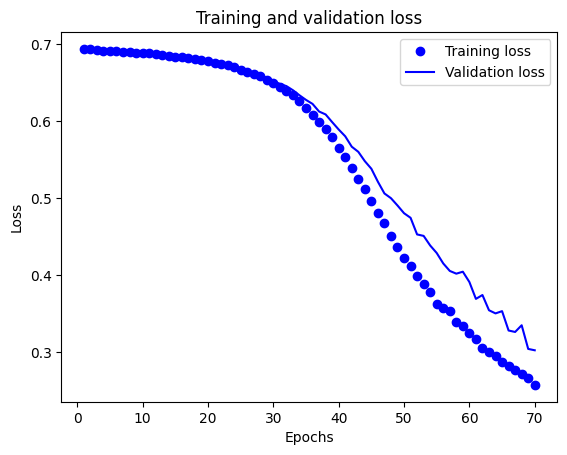

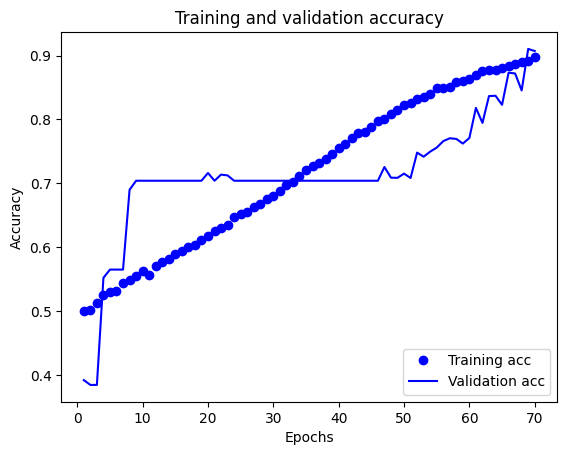


Classification Report
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      1527
           1       1.00      0.82      0.90      2432

    accuracy                           0.89      3959
   macro avg       0.89      0.91      0.89      3959
weighted avg       0.91      0.89      0.89      3959


Confusion Matrix
[[1527    0]
 [ 444 1988]]


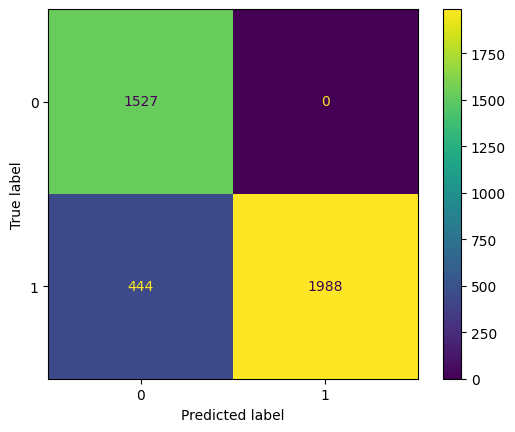

Time taken: 325.5905 seconds


In [ ]:
start_time_1 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=50, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(512, activation='relu'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=64, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time1 = time.perf_counter()
print(f"Time taken: {end_time1 - start_time_1:0.4f} seconds")

# Optimizing the model
Instead of looking at random number ranges for learning rates, filters, and hidden units, we have encoded specific values.

The hyper parameters we are attempting to optimize are:

*   Batch Size
*   Activation Functions
*   Learning Rates
*   Filters
*   Hidden Units


The base CNN model we made is ingested into *objective_function*.
  This is where our hyper parameters are being considered.
  It returns the Accuracy of that particular iteration.
**LB** and **UB** is set according to the list given above.



In [ ]:
BATCH_ENCODER = LabelEncoder()
BATCH_ENCODER.fit([32, 64, 128])

#act encoder --> Which activation function should be used?
ACT_ENCODER = LabelEncoder()
ACT_ENCODER.fit(['softmax', 'softplus', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'])

#Learning Rate encoder
LR_ENCODER = LabelEncoder()
LR_ENCODER.fit([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])

#Filter encoder
FILTER_ENCODER = LabelEncoder()
FILTER_ENCODER.fit([25, 50, 75])

#Hidden Units encoder
HIDDEN_ENCODER = LabelEncoder()
HIDDEN_ENCODER.fit([400, 512, 640])

def objective_function(params):
  '''RULES:
      Batch Size - 32, 64, 128
      Activation - softmax, softplus, relu, tanh, sigmoid, hard_sigmoid, linear
      Learning Rate - 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1
      Filters - 25, 50, 75
      Hidden Units - 400, 512, 640
      Dense Layers - 5, 8, 10
  '''
  batch_size = BATCH_ENCODER.inverse_transform([int(params[0])])[0]
  activation = ACT_ENCODER.inverse_transform([int(params[1])])[0]
  learning_rate = LR_ENCODER.inverse_transform([int(params[2])])[0]
  filter = FILTER_ENCODER.inverse_transform([int(params[3])])[0]
  hidden_units = HIDDEN_ENCODER.inverse_transform([int(params[4])])[0]

  model = tensorflow.keras.Sequential()
  model.add(tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1], X_rebalance.shape[2]))),
  model.add(tensorflow.keras.layers.Conv1D(filters=filter, kernel_size=3, activation='sigmoid')),
  model.add(tensorflow.keras.layers.MaxPooling1D(pool_size=2)),
  model.add(tensorflow.keras.layers.Dropout(0.3)),
  model.add(tensorflow.keras.layers.BatchNormalization()),
  model.add(tensorflow.keras.layers.LSTM(64)),
  model.add(tensorflow.keras.layers.Flatten()),
  model.add(tensorflow.keras.layers.Dense(int(hidden_units), activation=activation)),
  model.add(tensorflow.keras.layers.Dropout(0.5)),
  model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))


  optimizer = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  history = model.fit(X_rebalance, y_rebalance, batch_size=batch_size, epochs=15, validation_data=(X_validation_encode, y_validation_encode), verbose=0)
  min_validation_accuracy = 1-history.history['val_accuracy'][-1]
  print(f"Accuracy {min_validation_accuracy}")
  return min_validation_accuracy

LB = [0, 0, 0, 0, 0]
UB = [2.99, 6.99, 5.99, 2.99, 2.99]

problem_dict = {
    "obj_func": objective_function,
    "bounds": FloatVar(lb=LB, ub=UB),
    "minmax": "min",
    "verbose": True
}

model = SOA.OriginalSOA(epoch=15, pop_size=20, fc=2)
g_best = model.solve(problem_dict)
print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")
print(f"Solution: {model.g_best.solution}, Fitness: {model.g_best.target.fitness}")
model.history.save_global_objectives_chart(filename="hello/goc")
model.history.save_local_objectives_chart(filename="hello/loc")

model.history.save_global_best_fitness_chart(filename="hello/gbfc")
model.history.save_local_best_fitness_chart(filename="hello/lbfc")

model.history.save_runtime_chart(filename="hello/rtc")

model.history.save_exploration_exploitation_chart(filename="hello/eec")

model.history.save_diversity_chart(filename="hello/dc")

INFO:mealpy.bio_based.SOA.OriginalSOA:Solving single objective optimization problem.


Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.0
Accuracy 0.4008588194847107
Accuracy 0.057842910289764404
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.0
Accuracy 0.3430159091949463
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.38494569063186646
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.19045215845108032
Accuracy 0.5991412103176117
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.20636522769927979
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.6150543093681335


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 1, Current best: 0.0, Global best: 0.0, Runtime: 1571.88289 seconds


Accuracy 0.3427633047103882
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.38494569063186646
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.38494569063186646


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 2, Current best: 0.0, Global best: 0.0, Runtime: 1270.44059 seconds


Accuracy 0.0
Accuracy 0.14852237701416016
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.41879260540008545
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.6150543093681335
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.0


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 3, Current best: 0.0, Global best: 0.0, Runtime: 1270.09985 seconds


Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.38494569063186646
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 4, Current best: 0.0, Global best: 0.0, Runtime: 1556.76731 seconds


Accuracy 0.38494569063186646
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.38494569063186646
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.38494569063186646
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.0


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 5, Current best: 0.0, Global best: 0.0, Runtime: 1460.99015 seconds


Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.38494569063186646
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.0
Accuracy 0.19045215845108032
Accuracy 0.6150543093681335


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 6, Current best: 0.0, Global best: 0.0, Runtime: 1583.07552 seconds


Accuracy 0.598130851984024
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.04849708080291748
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.38494569063186646


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 7, Current best: 0.0, Global best: 0.0, Runtime: 1585.71689 seconds


Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.2048497200012207
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.0


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 8, Current best: 0.0, Global best: 0.0, Runtime: 1374.88073 seconds


Accuracy 0.38494569063186646
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.38494569063186646
Accuracy 0.38494569063186646
Accuracy 0.38494569063186646
Accuracy 0.38494569063186646
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.0
Accuracy 0.4885072112083435
Accuracy 0.0
Accuracy 0.2194998860359192


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 9, Current best: 0.0, Global best: 0.0, Runtime: 1588.44794 seconds


Accuracy 0.05354887247085571
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.6150543093681335
Accuracy 0.0


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 10, Current best: 0.0, Global best: 0.0, Runtime: 1489.07320 seconds


Accuracy 0.6150543093681335
Accuracy 0.6150543093681335
Accuracy 0.0
Accuracy 0.0
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.6150543093681335
Accuracy 0.38494569063186646
Accuracy 0.38494569063186646
Accuracy 0.6150543093681335
Accuracy 0.38494569063186646
Accuracy 0.0
Accuracy 0.3604445457458496
Accuracy 0.38494569063186646
Accuracy 0.0


Solution: Solution: [2.99       1.8882204  2.05132718 2.99       2.99      ], Fitness: 0.09548252820968628


Batch Size - 32, 64, **128**

Activation - softmax, **softplus**, relu, tanh, sigmoid, hard_sigmoid, linear

Learning Rate - 0.0005, 0.001, **0.005**, 0.01, 0.05, 0.1

Filters - 25, 50, **75**

Hidden Units - 400, 512, **640**

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 75)          │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 75)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 75)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 75)          │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 640)            │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           641 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,681 (307.35 KB)

 Trainable params: 78,531 (306.76 KB)

 Non-trainable params: 150 (600.00 B)

Epoch 1/70
309/309 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4957 - loss: 0.8008 - val_accuracy: 0.6151 - val_loss: 0.6783
Epoch 2/70
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5074 - loss: 0.7699 - val_accuracy: 0.3849 - val_loss: 0.7036
Epoch 3/70
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5028 - loss: 0.7458 - val_accuracy: 0.3849 - val_loss: 0.7266
Epoch 4/70
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5005 - loss: 0.7375 - val_accuracy: 0.6151 - val_loss: 0.6776
Epoch 5/70
309/309 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5076 - loss: 0.7211 - val_accuracy: 0.3849 - val_loss: 0.6928
Epoch 6/70
309/309 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5061 - loss: 0.7134 - val_accuracy: 0.3849 - val_loss: 0.7115
Epoch 7/70
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5063 - loss: 0.7076 - val_accuracy: 0.3849 - val_loss: 0.6959
Epoch 8/70
309/309 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5106 - loss: 0.7018 - val_accuracy

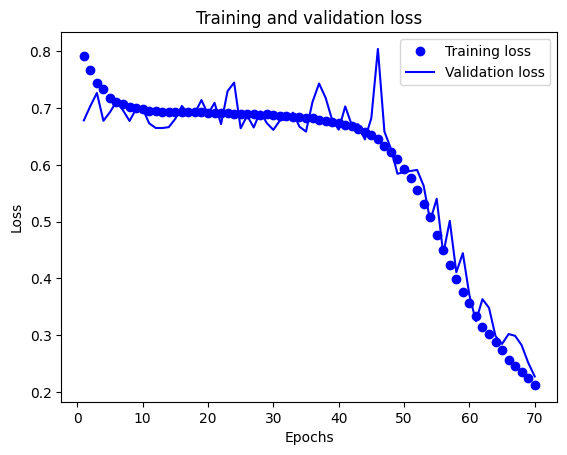

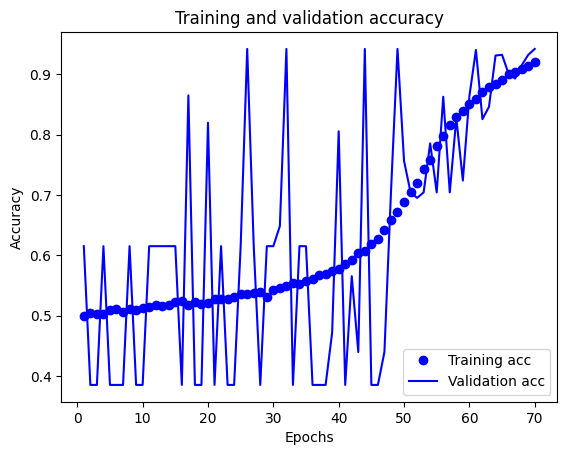


Classification Report
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1527
           1       1.00      0.89      0.94      2432

    accuracy                           0.93      3959
   macro avg       0.93      0.95      0.93      3959
weighted avg       0.94      0.93      0.93      3959


Confusion Matrix
[[1527    0]
 [ 265 2167]]


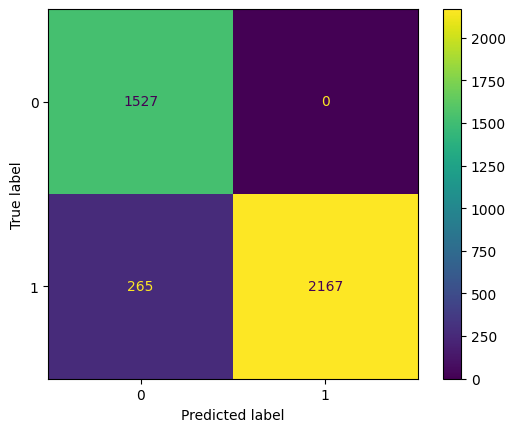

Time taken: 312.1350 seconds


In [ ]:

start_time_2 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=75, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(640, activation='softplus'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.005)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=128, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time2 = time.perf_counter()
print(f"Time taken: {end_time2 - start_time_2:0.4f} seconds")